In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# 0. Setup

In [ ]:
import numpy as np
import pandas as pd
import random
import math
np.random.seed(42)

import matplotlib.pyplot as plt
FONTSIZE = 16
params = {
         'figure.figsize' : (6,6),
         'axes.labelsize' : FONTSIZE,
         'axes.titlesize' : FONTSIZE+2,
         'legend.fontsize': FONTSIZE,
         'xtick.labelsize': FONTSIZE,
         'ytick.labelsize': FONTSIZE,
         'xtick.color'    : 'black',
         'ytick.color'    : 'black',
         'axes.facecolor' : 'white',
         'axes.edgecolor' : 'black',
         'axes.titlepad'  :  20,
         'axes.labelpad'  :  10}
plt.rcParams.update(params)

XNAME = 'x1'; XLABEL = r'$x_1$'
YNAME = 'x2'; YLABEL = r'$x_2$'
RANGE = (-6, 6); STEP = 0.1

def predict(output_node, boundary_value):
  output_node.reshape(-1, 1, 1) # a list (m, 1, 1)
  predictions = np.array(output_node > boundary_value, dtype=int)
  return predictions

def plot_cost_vs_iter(train_costs, test_costs, title="Cost evolution"):

  fig, ax = plt.subplots(figsize=(8, 6))
  iters = np.arange(1,len(train_costs)+1)
  ax.plot(iters, train_costs, color='red', lw=1, label='Training set')
  ax.plot(iters, test_costs, color='blue', lw=1, label='Testing set')
  ax.set_xlabel("Number of iterations"); ax.set_xlim(1, iters[-1])
  ax.set_ylabel("Cost")
  ax.legend(loc="upper right", frameon=False)
  ax.set_title(title)
  plt.show()


def get_decision_surface(weights, biases, boundary=0.5, range=RANGE, step=STEP):

  # Create a grid of points spanning the parameter space:
  x1v, x2v = np.meshgrid(np.arange(range[0], range[1]+step, step),
                         np.arange(range[0], range[1]+step, step))
  
  # Stack it so that it is shaped like X_train: (m,2)
  X_grid = np.c_[x1v.ravel(), x2v.ravel()].reshape(-1,2)

  # Feedforward on all grid points and get binary predictions:
  output = feedforward(X_grid, weights, biases)[-1] # getting only output node
  Ypred_grid = predict(output, boundary)

  return (x1v, x2v, Ypred_grid.reshape(x1v.shape))


def plot_scatter(sig, bkg, ds=None, xname=XNAME, xlabel=XLABEL, yname=YNAME, ylabel=YLABEL, range=RANGE, step=STEP, title="Scatter plot"):

  fig, ax = plt.subplots()

  # Decision surface
  if ds:
    (xx, yy, Z) = ds # unpack contour data
    cs = plt.contourf(xx, yy, Z, levels=[0,0.5,1], colors=['orange','dodgerblue'], alpha=0.3)

  # Scatter signal and background:
  ax.scatter(sig[xname], sig[yname], marker='o', s=10, c='dodgerblue', alpha=1, label='Positive class')
  ax.scatter(bkg[xname], bkg[yname], marker='o', s=10, c='orange',     alpha=1, label='Negative class')

  # Axes, legend and plot:
  ax.set_xlim(range); ax.set_xlabel(xlabel)
  ax.set_ylim(range); ax.set_ylabel(ylabel)

  ax.legend(bbox_to_anchor=(1.04, 0.5), loc="center left", frameon=False) 
  ax.set_title(title)
  plt.show()

# 1. Get the data

## 1.1 : Récupérer le fichier de données

In [ ]:
# Let upload and read the train and test set

train = pd.read_csv("/content/gdrive/MyDrive/Colab_Notebook/AIMS_ML/ml_a3_data_train.csv")
test = pd.read_csv("/content/gdrive/MyDrive/Colab_Notebook/AIMS_ML/ml_a3_data_test.csv")

In [ ]:
# Let see the number of sample on each 

train.shape

(320, 3)

As we can see, our train dataset has 320 sample, corresponding here by the number of rows oe numbers of observations

In [ ]:
test.shape

(80, 3)

using the same logic, we conclude that, the test set has 80 samples. 

<font color='red'>Data correctly loaded. Why are you writing in French?</font>

In [ ]:
# one thing, we can show the first five rows of the train dataset to see how the data look like
train.head()

,x1,x2,class
0,-0.136282,3.244889,0
1,-5.305888,5.629232,0
2,-4.147647,-0.226319,1
3,-2.170794,3.946986,0
4,-5.555908,1.155239,0


In [ ]:
# In our data, the column <<class>> containt the labels. 
# to see the dofferents columns of data, we can use the following command: 
train.columns

Index(['x1', 'x2', 'class'], dtype='object')

In [ ]:
# the column containg the labels is then given by the command : 
train.columns[2]

'class'

As we can see, the class values of our labels is 0 and 1

<font color='red'>Correct!</font>

## 1.2: Split signal vs background

In [ ]:
sig = train.loc[train['class']==1]   

In [ ]:
sig.head()

,x1,x2,class
2,-4.147647,-0.226319,1
6,0.332413,5.915578,1
9,4.031761,2.351690,1
10,-4.655533,-1.225733,1
11,-0.341086,-1.057909,1


In [ ]:
bkg = train.loc[train['class']==0] 

In [ ]:
bkg.head()

,x1,x2,class
0,-0.136282,3.244889,0
1,-5.305888,5.629232,0
3,-2.170794,3.946986,0
4,-5.555908,1.155239,0
5,-2.775872,0.499611,0


In [ ]:
# let's check if the spilt of our dataframe is going well

if(sig.shape[0]+bkg.shape[0] == train.shape[0]):
  print("Datatrain spilt successfully")
else:
  print("missing value during the split")

Datatrain spilt successfully


<font color='red'>Correct split of data.</font>

## 1.3: Dataframe to NumPy

Here it ask to us to declare the variables to store the dataset into NumPy arrays:

In [ ]:
inputs = ['x1', 'x2']
X_train = train[inputs].to_numpy()
y_train = train['class'].to_numpy()

X_test =  test[inputs].to_numpy()
y_test = test['class'].to_numpy()

In [ ]:
# Let's do some test to see of everything is ok !!!

X_train[:5]  # To see the first five lines of our new array

array([[-0.13628172,  3.24488901],
       [-5.30588788,  5.62923156],
       [-4.14764742, -0.22631878],
       [-2.17079432,  3.94698569],
       [-5.55590838,  1.15523854]])

In [ ]:
y_train[:5]

array([0, 0, 1, 0, 0])

In [ ]:
X_test[:5]

array([[ 3.96743289,  5.58032293],
       [-5.32436069, -4.574185  ],
       [ 5.63501553,  3.30159388],
       [ 2.36904321, -2.43181191],
       [ 3.60704039, -3.59819707]])

In [ ]:
y_test[:5]

array([1, 1, 1, 0, 0])

# 2. Functions

## 2.1: Weighted Sum

Here, our aim is to create the function z that compute the weighted sum of a given activation unit, as seen in class.

In [ ]:
def z(input, weight, bias):
  total=input @ weight 
  output = total + bias 
  return output

<font color='red'>Correct implementation of the $z$ function.</font>

## 2.2 : Fonctions d'activation et dérivées

In [ ]:
def tanhz(z):
    return np.tanh(z)

def sigmoid(z):
    return (1/(1 + np.exp(-z))) 

def sigmoid_prime(z):
    return (np.exp(-z)/(1 + np.exp(-z))**2)

def tanh_prime(z):
    return (1/(np.cosh(z))**2) 

<font color='red'>Correct implementation. However, you should have notice that the derivative of the sigmoid can make use of the sigmoid function. Similarly, you can make use of tanh to implement the derivative of tanh.</font>

## 2.3 : Fonction de coût d'entropie croisée

In [ ]:
def cross_entropy_cost(y_vals, y_preds):
  m = len(y_vals)
  total_residus = (y_vals*np.log(y_preds) + (1-y_vals)*np.log(1- y_preds))/(-m)
  return total_residus.sum()

<font color='red'>Mathematically correct! You however need to deal with the cases where the input of the log function is zero. This can be done by adding a small value such as 1e-9 to the argument of the $np.log$ function.</font>

## 2.4 : Dérivée de la perte

The loss function for the classification is given by: 

$$L\left ( \hat{y}^{(i)},y^{(i)} \right )=-\left [ y^{(i)}\log(\hat{y}^{(i)}) + \left ( 1-y^{(i)} \right )\log(1-\hat{y}^{(i)}) \right ]$$

Here, we have the find the derivative of previous loss function: 

In [ ]:
# here, we are going to use python to compute the derivative of previous loss function, before typing in markdown
from sympy import *

y_hat = Symbol("y_hat")
y = Symbol("y")

diff(-( y*log(y_hat)+(1-y)*log(1- y_hat)), y_hat)


-y/y_hat - (y - 1)/(1 - y_hat)

Then, we have: 

$$\dfrac{d L\left (\hat{y}^{(i)},y^{(i)}\right)}{d\hat{y}^{(i)}}=- \dfrac{y^{(i)}}{\hat{y}^{(i)}}-\dfrac{y^{(i)}-1}{1-\hat{y}^{(i)}} $$

<font color='red'>Mathematically correct implementation.</font>

In [ ]:
def L_prime(y_preds, y_obs):
    return (-(y_obs/y_preds) - ((y_obs - 1)/(1 - y_preds)))

<font color='red'>Mathematically correct, but we need to deal with cases where the denominator of any of the term is zero. To avoid this exception, you can add a small epsilon value (1e-9) to each term.</font>

# 3. Feedforward

It is time to write the feedforward function! Some information about the network: 

>The network has two hidden layers

> The nodes of the hidden layers use the hyperbolic tangent as activation function. 

>  The output layer uses the sigmoid function


 



## 3.1: Feedforward Propagation

In [ ]:
def feedforward(input_X, weights, biases):

  W1, W2, W3 = weights ; b1, b2, b3 = biases

  m  = len(input_X) 
  a0 = input_X.reshape((m, 1, -1))
  

  # First layer
  z1 = z(a0, W1, b1)
  a1 = tanhz(z1)

  # Second layer
  z2 = z(a1, W2, b2)
  a2 = tanhz(z2)

  # Third layer
  z3 = z(a2, W3, b3)
  a3 = sigmoid(z3)
  
  nodes = [a0, z1, a1, z2, a2, z3, a3]

  return nodes

<font color='red'>Correct implementation of the feedforward function.</font>

## 3.2: Predict




1.  The output_node in the context of our 2-hidden-layered neural network is given by **a3.**
2. The function predict return the **array** where the values are 0 or 1
3. After successfully executing the feedforward function, we call the function predict like: **predict(a3,0.5)**









<font color='red'>These answers are correct but you need to explicitly state how the output of the feedforward network is extracted. <br>predict(nodes[-1], 0.5)</font>

# 4. Neural Network Training

In [ ]:
np.random.seed??

In [ ]:
# Hyperparameters
alpha = 0.03
N = 2000 # epochs

# Initialization 
m = len(X_train)     # number of data samples
n = X_train.shape[1] # number of input features
q = 3 # number of nodes in first hidden layer
r = 2 # number of nodes in second hidden layer

# WEIGHT MATRICES + BIASES
np.random.seed(13) # To fix the value when we generate
W1 = np.random.random((n,q))
W2 = np.random.random((q,r))
W3 = np.random.random((r,1))
b1 = np.random.random((1,q))
b2 = np.random.random((1,r))
b3 = np.random.random((1,1))


# OUTPUT LAYER
y_train = np.reshape(y_train, (-1, 1, 1))
y_test  = np.reshape(y_test , (-1, 1, 1))

# Storing cost values for train and test datasets
costs_train = []
costs_test  = []
debug = False

print("Starting the training\n")

# -------------------
#   Start iterations
# -------------------
for t in range(1, N+1):

  # FORWARD PROPAGATION
  # Feedforward on test data:
  nodes_test =feedforward(X_test, [W1, W2, W3], [b1, b2, b3]) 
  ypreds_test = nodes_test[-1]

  # Feedforward on train data:
  a0, z1, a1, z2, a2, z3, a3 = feedforward(X_train, [W1, W2, W3], [b1, b2, b3])
  ypreds_train = a3

  # Cost computation and storage
  J_train = cross_entropy_cost(y_train, ypreds_train)
  J_test  = cross_entropy_cost(y_test, ypreds_test)
  costs_train.append(J_train)
  costs_test.append(J_test)

  if (t<=100 and t % 10 == 0) or (t>100 and t % 100 == 0):
      print(f"Iteration {t}\t Train cost = {J_train:.4f}  Test cost = {J_test:.4f}   Diff = {J_test-J_train:.5f}")

  # BACKWARD PROPAGATION
  # Errors delta:
  delta_3 = L_prime(ypreds_train, y_train)*sigmoid_prime(z3)
  delta_2 = (delta_3 @ W3.T)* tanh_prime(z2)
  delta_1 = (delta_2 @ W2.T)* tanh_prime(z1)
  
  # Partial derivatives:
  dCostdW3 = (1/m)*(np.sum(np.transpose(a2,(0,2,1))@ delta_3, axis=0))
  dCostdW2 = (1/m)*(np.sum(np.transpose(a1,(0,2,1))@ delta_2, axis=0))
  dCostdW1 = (1/m)*(np.sum(np.transpose(a0,(0,2,1))@ delta_1, axis=0)) 
  dCostdb3 = (1/m)*(np.sum(delta_3, axis=0))
  dCostdb2 = (1/m)*(np.sum(delta_2, axis=0))
  dCostdb1 = (1/m)*(np.sum(delta_1, axis=0))

  if debug and t<3:
    print(f"a0: {a0.shape} a1: {a1.shape} a2: {a2.shape} a3: {a3.shape} ")
    print(f"W3: {W3.shape} z1: {z1.shape} z2: {z2.shape} z3: {z3.shape} ")
    print(f"dCostdW3: {dCostdW3.shape} dCostdW2: {dCostdW2.shape} dCostdW1: {dCostdW1.shape}") 

  # Update of weights and biases
  W3 = W3 - alpha*dCostdW3
  W2 = W2 - alpha*dCostdW2
  W1 = W1 - alpha*dCostdW1
  b3 = b3 - alpha*dCostdb3  
  b2 = b2 - alpha*dCostdb2 
  b1 = b1 - alpha*dCostdb1 

print(f'\nEnd of gradient descent after {t} iterations')

Starting the training

Iteration 10	 Train cost = 0.8232  Test cost = 0.7557   Diff = -0.06755
Iteration 20	 Train cost = 0.7928  Test cost = 0.7345   Diff = -0.05835
Iteration 30	 Train cost = 0.7681  Test cost = 0.7181   Diff = -0.04998
Iteration 40	 Train cost = 0.7481  Test cost = 0.7057   Diff = -0.04240
Iteration 50	 Train cost = 0.7319  Test cost = 0.6963   Diff = -0.03560
Iteration 60	 Train cost = 0.7188  Test cost = 0.6893   Diff = -0.02953
Iteration 70	 Train cost = 0.7081  Test cost = 0.6840   Diff = -0.02412
Iteration 80	 Train cost = 0.6994  Test cost = 0.6801   Diff = -0.01931
Iteration 90	 Train cost = 0.6923  Test cost = 0.6772   Diff = -0.01505
Iteration 100	 Train cost = 0.6863  Test cost = 0.6750   Diff = -0.01128
Iteration 200	 Train cost = 0.6537  Test cost = 0.6625   Diff = 0.00874
Iteration 300	 Train cost = 0.6253  Test cost = 0.6388   Diff = 0.01351
Iteration 400	 Train cost = 0.5860  Test cost = 0.5992   Diff = 0.01325
Iteration 500	 Train cost = 0.5358  Test

<font color='red'>Good Job!</font>

# 5. Plots

## 5.1: Cost evolution

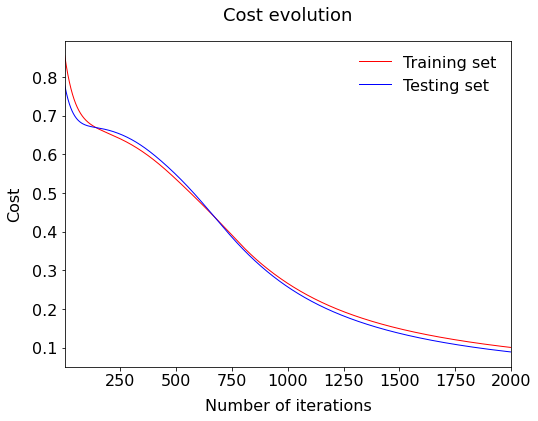

In [ ]:
plot_cost_vs_iter(costs_train, costs_test, title="Cost evolution")

## 5.2: Scatter Plot

In [ ]:
decision = get_decision_surface([W1, W2,W3], [b1, b2, b3], boundary=0.5, range=RANGE, step=STEP)

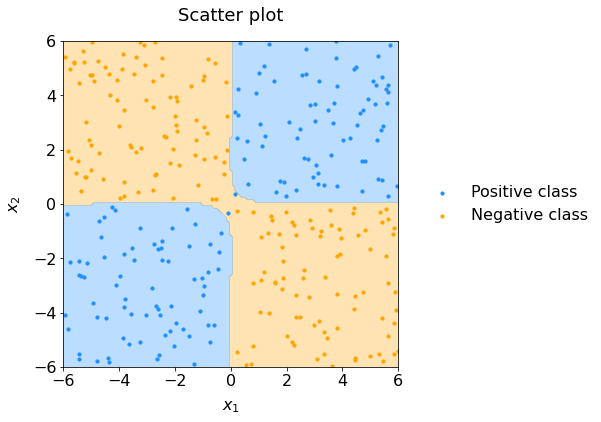

In [ ]:
plot_scatter(sig, bkg, ds=decision, xname=XNAME, xlabel=XLABEL, yname=YNAME, ylabel=YLABEL, range=RANGE, step=STEP, title="Scatter plot")

As we can see on the plot above, we can conclude that, our neural network successfully learn the XOR function. 

<font color='red'>Good Job! You were expected to plot the scatter data without the decision boundary on a separate plot first.</font>